Лабораторная работа 3. Классификация. Нейронные сети

Цель работы: изучение методов классификации данных, реализованные в библиотеке Scikit-Learn, а также ознакомление с нейронными сетями с использованием библиотек TensorFlow и TensorBoard.

Задачи:
1. Выбрать датасет, описать информацию о выбранном датасете, характеризовать признаки, провести предобработку данных.

2. Разбить данные на обучающий и тестовый наборы.

3. Построить классификационные модели с помощью пяти методов:

- наивный Байесовский классификатор (GaussianNB, MultinomialNB, ComplementNB, BernoulliNB);

- деревья решений (Decision Tree);

- линейный дискриминантный анализ (Linear Discriminant Analysis);

- метод опорных векторов (Support Vector Machines);

- метод ближайших соседей (k-Nearest Neighbors).

4. Сравнить качество работы классификаторов с помощью следующих метрик:

- accuracy (точность),

- precision (доля правильно классифицированных положительных примеров),

- recall (чувствительность, доля верно найденных положительных примеров),

- F1-Score (среднее гармоническое precision и recall),

- площадь под кривой ROC (AUC-ROC).

5. Настроить гиперпараметры каждого метода и провести исследование влияния различных параметров на качество классификации.

6. Реализовать и протестировать нейронную сеть на TensorFlow, исследовать эффект настройки гиперпараметров и визуализировать процесс обучения с помощью инструмента TensorBoard.

Выбранный датасет: Iris dataset: Классификация видов цветов Iris. <br> <br>
Описание датасета: в датасет включены три вида ирисов по 50 образцов в каждом, а также некоторые свойства каждого цветка.

Столбцы в датасете: <br>
SepalLengthCm - Длина чашелистика (в см) <br>
SepalWidthCm - Ширина чашелистика (в см) <br>
PetalLengthCm - Длина лепестка (в см)<br>
PetalWidthCm - Ширина лепестка (в см) <br>
Species - Название вида - целевой признак <br>

1. Загрузка данных

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import math

df = pd.read_csv('star_classification.csv')
df = df.replace('?', pd.NA).dropna()

# Определяем количество строк на каждый класс
samples_per_class = 10000 // 3  # ~3333

# Случайный шаффл (чтобы строки не были отсортированы по классам)
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

balanced_dfs = []
for class_name in df_shuffled['class'].unique():
    class_subset = df_shuffled[df_shuffled['class'] == class_name].head(samples_per_class)
    balanced_dfs.append(class_subset)

df_balanced = pd.concat(balanced_dfs).sample(frac=1, random_state=42).reset_index(drop=True)
print(df_balanced['class'].value_counts())
df = df_balanced
#df = df.iloc[:-90000]

columns_to_drop = ['obj_ID', 'run_ID', 'rerun_ID', 
                   'field_ID', 'spec_obj_ID', 'fiber_ID']
df = df.drop(columns=columns_to_drop)
print(f"Размер: {df.shape}")
print(df.describe())


class
STAR      3333
QSO       3333
GALAXY    3333
Name: count, dtype: int64
Размер: (9999, 12)
             alpha        delta            u            g            r  \
count  9999.000000  9999.000000  9999.000000  9999.000000  9999.000000   
mean    178.277087    24.642663    21.761594    20.495187    19.719896   
std      97.965607    19.769580     2.166039     1.965812     1.827624   
min       0.013337   -17.284791    10.996230    10.511390    10.068540   
25%     124.825200     5.165229    20.208780    19.095570    18.457365   
50%     181.692764    24.962180    21.753680    20.874980    20.187320   
75%     236.416362    40.877418    23.233580    21.860610    21.097950   
max     359.999810    82.947622    29.234380    26.881750    27.397090   

                 i            z      cam_col     redshift         plate  \
count  9999.000000  9999.000000  9999.000000  9999.000000   9999.000000   
mean     19.277994    19.013666     3.509951     0.705991   5397.335234   
std       1.

In [32]:
numeric_columns = df.select_dtypes(include=[np.number]).columns

print("\nАсимметрия:")
for col in numeric_columns:
    skew_val = skew(df[col].dropna())
    print(f"{col:20s}: {skew_val:8.3f}")

print("\nЭксцесс:")
for col in numeric_columns:
    kurt_val = kurtosis(df[col].dropna())
    print(f"{col:20s}: {kurt_val:8.3f}")

print("\nМода:")
for col in numeric_columns:
    mode_value = df[col].mode()
    print(f"{col:20s}: {mode_value.iloc[0]}")


Асимметрия:
alpha               :   -0.012
delta               :    0.125
u                   :    0.012
g                   :   -0.424
r                   :   -0.650
i                   :   -0.551
z                   :   -0.463
cam_col             :   -0.027
redshift            :    1.788
plate               :    0.127
MJD                 :   -0.438

Эксцесс:
alpha               :   -0.616
delta               :   -1.099
u                   :   -0.283
g                   :   -0.077
r                   :   -0.054
i                   :   -0.062
z                   :   -0.190
cam_col             :   -1.114
redshift            :    4.640
plate               :   -0.968
MJD                 :   -0.699

Мода:
alpha               : 0.0133366618319997
delta               : -17.2847913705915
u                   : 24.63465
g                   : 16.82076
r                   : 20.54841
i                   : 19.64404
z                   : 22.8269
cam_col             : 4
redshift            : 0.0
pla

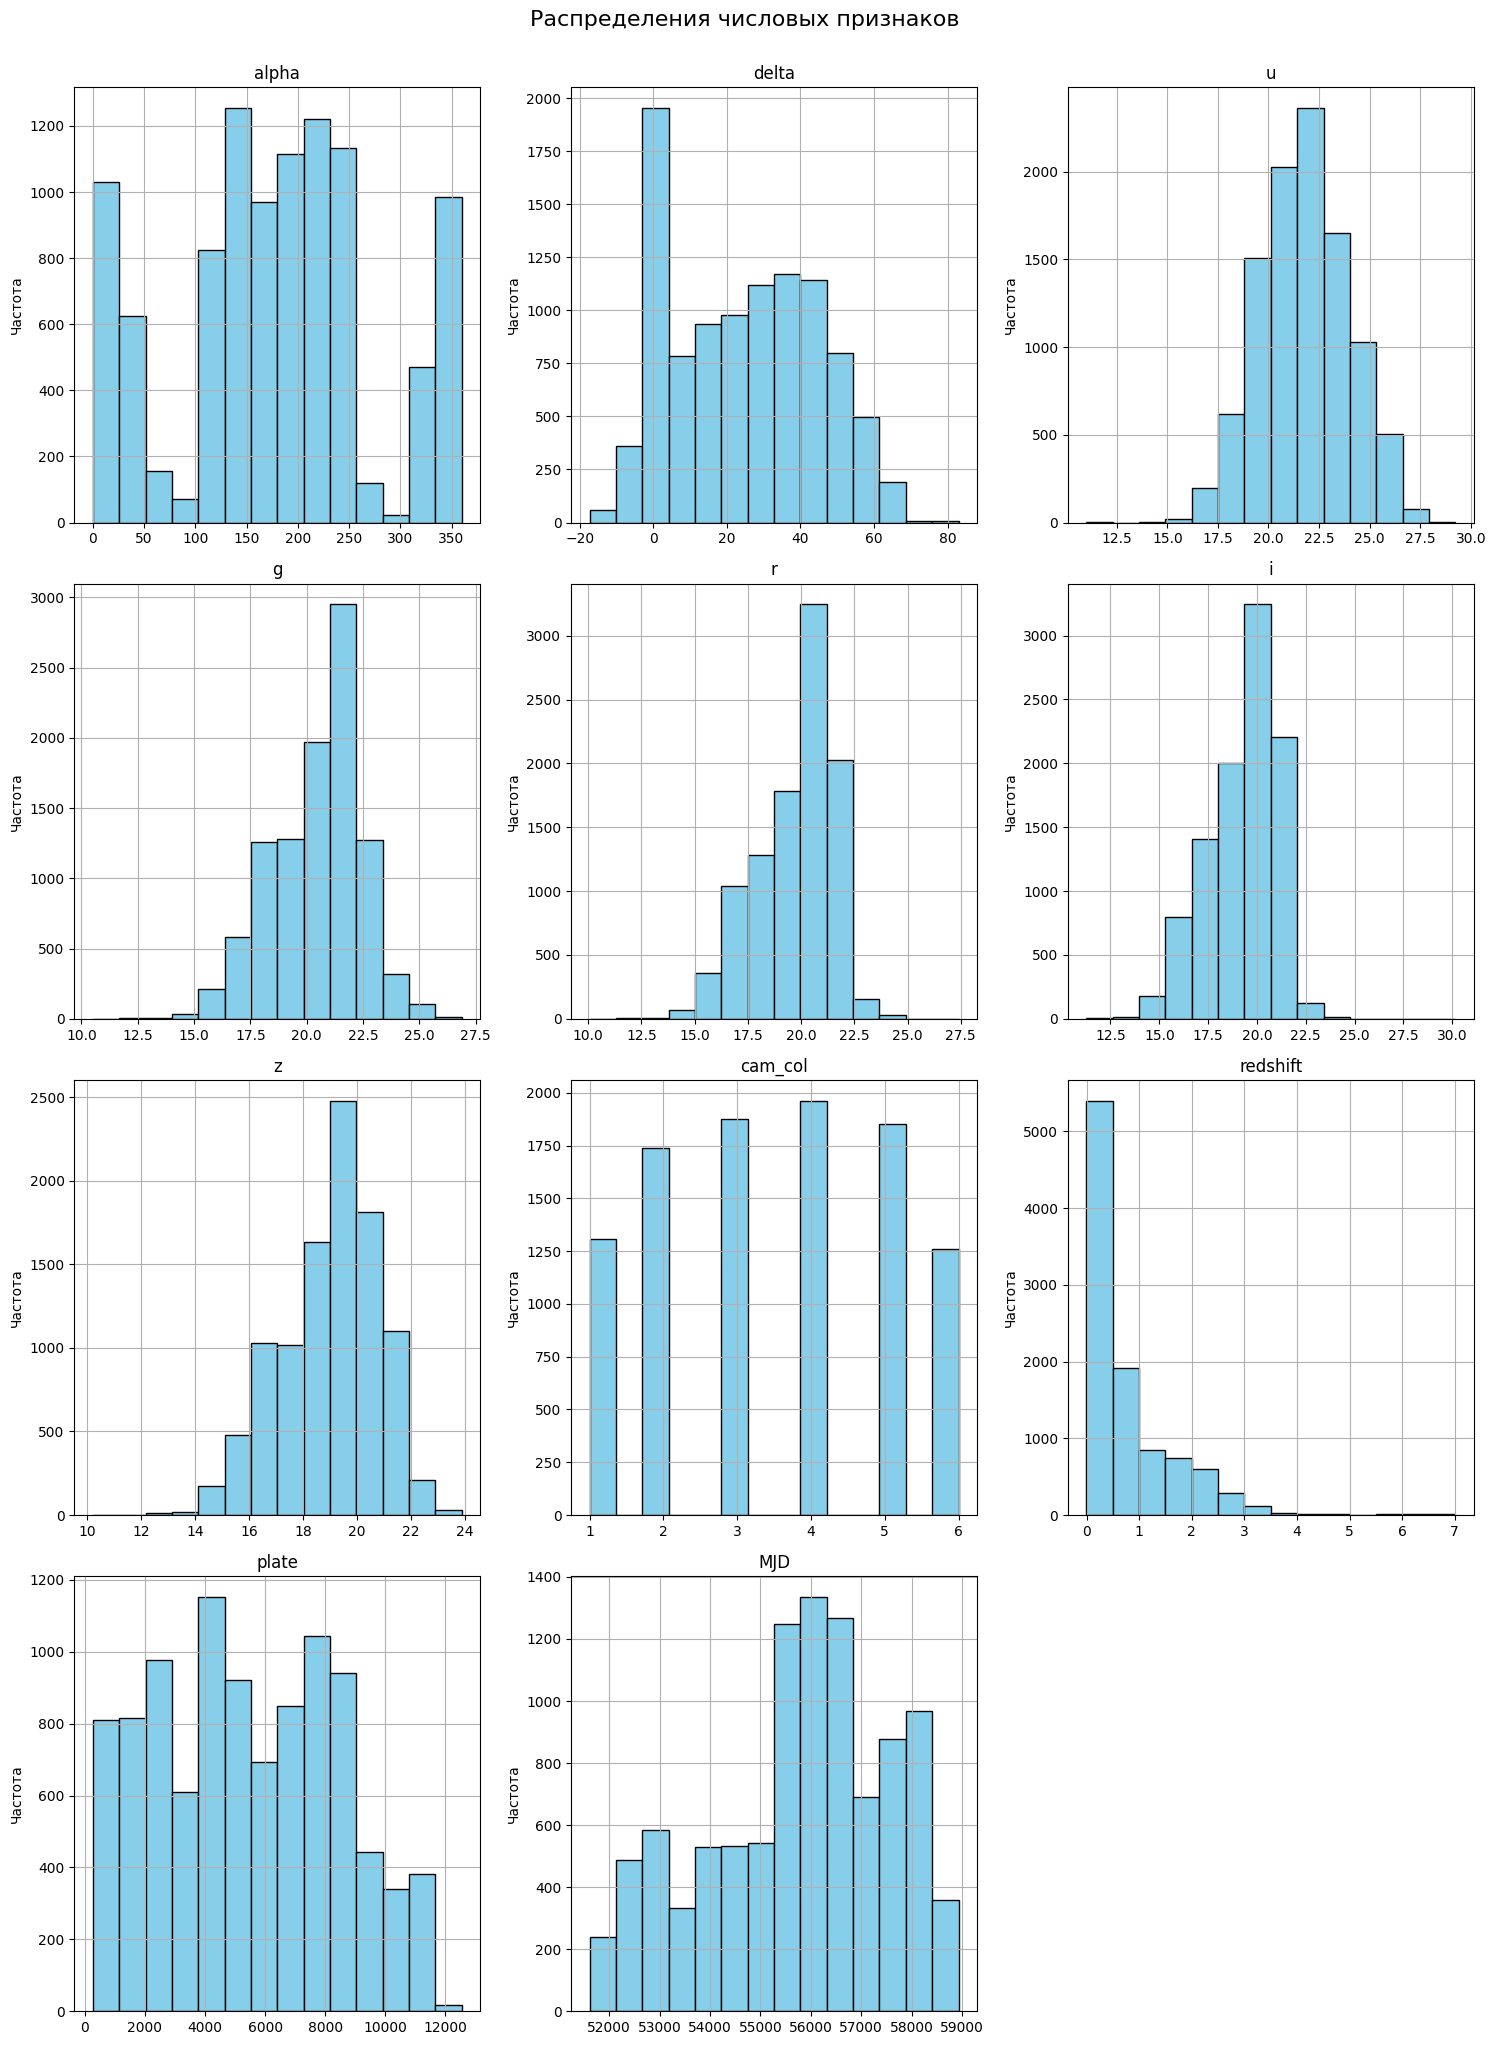

In [33]:
count_intervals = int(1 + math.log2(df.shape[0]))

n_features = len(numeric_columns)
n_subplot_cols = 3
n_subplot_rows = math.ceil(n_features / n_subplot_cols)  
fig, axes = plt.subplots(n_subplot_rows, n_subplot_cols, figsize=(15, 5 * n_subplot_rows))
axes = axes.flatten() if n_subplot_rows > 1 else axes  
for i, col in enumerate(numeric_columns):
    df[col].hist(bins=count_intervals, ax=axes[i], 
                 color='skyblue', edgecolor='black')
    axes[i].set_title(col)  
    axes[i].set_ylabel('Частота')

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.suptitle("Распределения числовых признаков", y=1.02, fontsize=16)
plt.show()